In [1]:
%load_ext autoreload
%autoreload 2


from functools import partial

import numpy as np

import scqubits as scq


from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix, lumped_oscillator_from_path, extract_transmon_coupled_Noscillator
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem, QuantumSystemRegistry, QuantumBuilder
from qiskit_metal.analyses.hamiltonian.states_energies import extract_energies
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength

                        
from scipy.constants import speed_of_light as c_light
from pyEPR.calcs.constants import e_el as ele, hbar

import matplotlib.pyplot as plt
%matplotlib inline

01:59PM 47s INFO [__init__]: TransmonBuilder with system_type TRANSMON registered to QuantumSystemRegistry
01:59PM 47s INFO [__init__]: FluxoniumBuilder with system_type FLUXONIUM registered to QuantumSystemRegistry
01:59PM 47s INFO [__init__]: TLResonatorBuilder with system_type TL_RESONATOR registered to QuantumSystemRegistry
01:59PM 47s INFO [__init__]: LumpedResonatorBuilder with system_type LUMPED_RESONATOR registered to QuantumSystemRegistry


In [2]:
MHzRad = 2 * np.pi * 1e6
GHzRad = 2 * np.pi * 1e9

### load fluxonium cell Q3d simulation results

In [3]:
path = './Fluxonium_8p5MHz_cmat.txt'
flux_mat, _, _, _ = load_q3d_capacitance_matrix(path)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Fluxonium_8p5MHz_cmat.txt


,ground_main_plane,pad_bot_Q1,pad_top_Q1,coupling_pad_Q1
ground_main_plane,149.81,-24.45,-27.87,-35.54
pad_bot_Q1,-24.45,40.31,-5.38,-8.51
pad_top_Q1,-27.87,-5.38,36.66,-1.23
coupling_pad_Q1,-35.54,-8.51,-1.23,46.36


### load transmon cell Q3d simulation results

In [4]:
path = './Transmon_5p5GHz_fQ_cmat.txt'
transmon_mat, _, _, _ = load_q3d_capacitance_matrix(path)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Transmon_5p5GHz_fQ_cmat.txt


,ground_main_plane,pad_bot_Q2,pad_top_Q2,coupling_pad_Q2
ground_main_plane,179.08,-38.07,-44.06,-36.24
pad_bot_Q2,-38.07,91.64,-31.54,-19.11
pad_top_Q2,-44.06,-31.54,81.23,-2.32
coupling_pad_Q2,-36.24,-19.11,-2.32,58.75


### Create LOM cells from capacitance matrices

In [5]:
# cell 1

opt1 = dict(
    node_rename = {'coupling_pad_Q1': 'coupling'}, 
    cap_mat = flux_mat,
    ind_dict = {('pad_bot_Q1', 'pad_top_Q1'): 1},  # placeholder inductance here; only used for node-basis transformation and reduction
    jj_dict = {('pad_bot_Q1', 'pad_top_Q1'):'j1'},
)
cell_1 = Cell(opt1)

# cell 2
opt2 = dict(
    node_rename = {'coupling_pad_Q2': 'coupling'},
    cap_mat = transmon_mat,
    ind_dict = {('pad_bot_Q2', 'pad_top_Q2'): 12.31},
    jj_dict = {('pad_bot_Q2', 'pad_top_Q2'):'j2'},
)
cell_2 = Cell(opt2)

### Make subsystems

In [6]:
# subsystem 1: fluxonium
fluxonium = Subsystem(name='fluxonium', sys_type='FLUXONIUM', nodes=['j1'], q_opts={'EJ':4860, 'EL':1140, 'flux': .5})


# subsystem 2: transmon
transmon = Subsystem(name='transmon', sys_type='TRANSMON', nodes=['j2'], q_opts={'ncut': 150, 'truncated_dim':10})

### Creat the composite system from the cells and the subsystems

In [7]:
composite_sys = CompositeSystem(
    subsystems=[fluxonium, transmon], 
    cells=[cell_1, cell_2], 
    grd_node='ground_main_plane')

In [8]:
cg = composite_sys.circuitGraph()
print(cg)

node_jj_basis:
-------------

['j1', 'pad_top_Q1', 'j2', 'pad_top_Q2', 'coupling']

nodes_keep:
-------------

['j1', 'j2']


L_inv_k (reduced inverse inductance matrix):
-------------

     j1        j2
j1  1.0  0.000000
j2  0.0  0.081235

C_k (reduced capacitance matrix):
-------------

           j1         j2
j1  21.769175  -0.249771
j2  -0.249771  58.195757




### Generate the hilberspace from the composite system, leveraging the scqubits package

In [9]:
hilbertspace = composite_sys.create_hilbertspace()
hilbertspace = composite_sys.add_interaction()
print(hilbertspace)

HilbertSpace:  subsystems
-------------------------

Fluxonium-----------| [Fluxonium_2]
                    | EJ: 4860
                    | EC: 889.8446120935232
                    | EL: 1140
                    | flux: 0.5
                    | cutoff: 110
                    | truncated_dim: 10
                    |
                    | dim: 110


Transmon------------| [Transmon_2]
                    | EJ: 13278.758148398147
                    | EC: 332.8624670156746
                    | ng: 0.001
                    | ncut: 150
                    | truncated_dim: 10
                    |
                    | dim: 301



HilbertSpace:  interaction terms
--------------------------------
InteractionTerm----------| [Interaction_1]
                         | g_strength: 30.553058474092207
                         | operator_list: [(0, array([[ 0.+0.j        , -0.-0.44731161j,  0. ...
                         | add_hc: False




### Print the results

In [10]:
hamiltonian_results = composite_sys.hamiltonian_results(hilbertspace, evals_count=30)

Finished eigensystem.     

system frequencies in GHz:
--------------------------
{'fluxonium': 0.3601817422175382, 'transmon': 5.591162362502447}

Chi matrices in MHz
--------------------------
             fluxonium    transmon
fluxonium  3293.889946    0.451843
transmon      0.451843 -391.649924


In [11]:
hamiltonian_results['chi_in_MHz'].to_dataframe()

,fluxonium,transmon
fluxonium,3293.889946,0.451843
transmon,0.451843,-391.649924


In [12]:
composite_sys.compute_gs()

           fluxonium   transmon
fluxonium   0.000000  30.553058
transmon   30.553058   0.000000

In [13]:
fluxonium.h_params

{'EJ': 4860,
 'EC': 889.8446120935232,
 'EL': 1140,
 'flux': 0.5,
 'Q_zpf': 3.204353268e-19,
 'default_charge_op': Operator(op=array([[ 0.+0.j        , -0.-0.44731161j,  0.+0.j        , ...,
          0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
        [ 0.+0.44731161j,  0.+0.j        , -0.-0.63259415j, ...,
          0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
        [ 0.+0.j        ,  0.+0.63259415j,  0.+0.j        , ...,
          0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
        ...,
        [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        , ...,
          0.+0.j        , -0.-4.64859865j,  0.+0.j        ],
        [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        , ...,
          0.+4.64859865j,  0.+0.j        , -0.-4.67007036j],
        [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        , ...,
          0.+0.j        ,  0.+4.67007036j,  0.+0.j        ]]), add_hc=False)}

In [14]:
transmon.h_params

{'EJ': 13278.758148398147,
 'EC': 332.8624670156746,
 'Q_zpf': 3.204353268e-19,
 'default_charge_op': Operator(op=array([[-150,    0,    0, ...,    0,    0,    0],
        [   0, -149,    0, ...,    0,    0,    0],
        [   0,    0, -148, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,  148,    0,    0],
        [   0,    0,    0, ...,    0,  149,    0],
        [   0,    0,    0, ...,    0,    0,  150]]), add_hc=False)}

### let's sweep some parameters now

In [15]:
 _sys = hilbertspace.subsys_list[0] # fluxonium

def update_hilbertspace(param_val):
    _sys.flux = param_val
    
param_name = 'flux'
param_vals = np.linspace(0, 1, 101)

sweep = scq.ParameterSweep(
    paramvals_by_name={param_name: param_vals},
    evals_count=30,
    hilbertspace=hilbertspace,
    subsys_update_info={param_name: [_sys]},
    update_hilbertspace=update_hilbertspace,
)

Bare spectra:   0%|          | 0/101 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/101 [00:00<?, ?it/s]

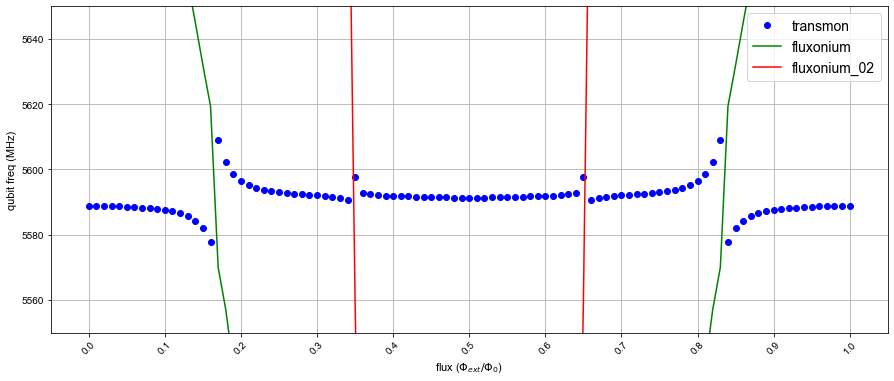

In [16]:
wq_t = sweep.transitions(False, [],(0, 0), (0, 1))[1][0]
wq_f = sweep.transitions(False, [],(0, 0), (1, 0))[1][0]
wq_f_02 = sweep.transitions(False, [],(0, 0), (2, 0))[1][0]


plt.figure(figsize=(15, 6))
plt.plot(param_vals, wq_t, 'ob', label='transmon')
plt.plot(param_vals, wq_f, 'g-', label='fluxonium')
plt.plot(param_vals, wq_f_02, 'r-', label='fluxonium_02')


plt.xticks(param_vals[::10], rotation=45)

plt.xlabel(r'flux ($\Phi_{ext}/\Phi_0$)')
plt.ylabel(r'qubit freq (MHz)')
plt.ylim([5550, 5650])

plt.grid()
plt.legend(fontsize=14)

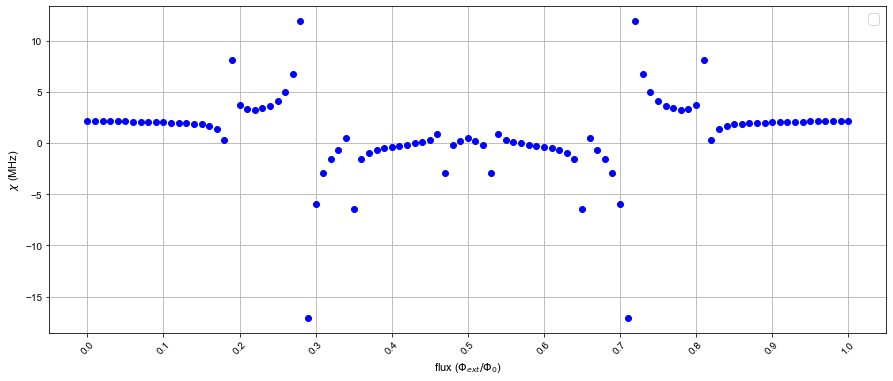

In [17]:
wq_f = sweep.transitions(False, [],(0, 0), (1, 0))[1][0]
wq_f_t = sweep.transitions(False, [],(0, 1), (1, 1))[1][0]


chi = wq_f_t - wq_f

plt.figure(figsize=(15, 6))
plt.plot(param_vals, chi, 'ob')

plt.xticks(param_vals[::10], rotation=45)

plt.xlabel(r'flux ($\Phi_{ext}/\Phi_0$)')
plt.ylabel(r'$\chi$ (MHz)')
#plt.ylim([5550, 5650])

plt.grid()
plt.legend(fontsize=14)

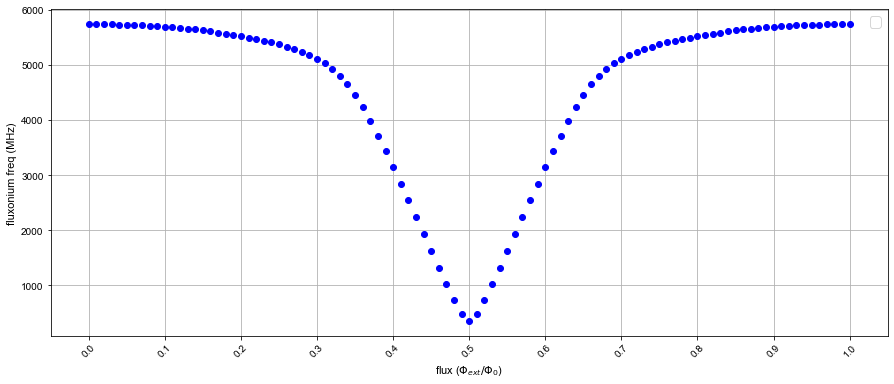

In [18]:
wq_f = sweep.transitions(False, [],(0, 0), (1, 0))[1][0]


plt.figure(figsize=(15, 6))
plt.plot(param_vals, wq_f, 'ob')


plt.xticks(param_vals[::10], rotation=45)

plt.xlabel(r'flux ($\Phi_{ext}/\Phi_0$)')
plt.ylabel(r'fluxonium freq (MHz)')

plt.grid()
plt.legend(fontsize=14)

In [19]:
scq.get_units()
scq.set_units('MHz')

 /opt/anaconda3/envs/metal/lib/python3.7/site-packages/scqubits/core/units.py: 50


'MHz'

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

See documentation for details.
This warning can be disabled by executing:
scqubits.settings.T1_DEFAULT_WARNING=False

 /opt/anaconda3/envs/metal/lib/python3.7/site-packages/scqubits/core/noise.py: 1187


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'t1_effective'}, xlabel='flux', ylabel='$\\mu s$'>)

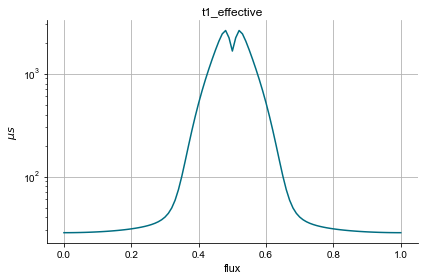

In [20]:
_sys.plot_t1_effective_vs_paramvals(param_name='flux', 
                                    param_vals=param_vals)

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 576x864 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'tphi_1_over_f_cc'}, xlabel='flux', ylabel='$\\mu s$'>,
         <AxesSubplot:title={'center':'tphi_1_over_f_flux'}, xlabel='flux', ylabel='$\\mu s$'>],
        [<AxesSubplot:title={'center':'t1_capacitive'}, xlabel='flux', ylabel='$\\mu s$'>,
         <AxesSubplot:title={'center':'t1_charge_impedance'}, xlabel='flux', ylabel='$\\mu s$'>],
        [<AxesSubplot:title={'center':'t1_flux_bias_line'}, xlabel='flux', ylabel='$\\mu s$'>,
         <AxesSubplot:title={'center':'t1_inductive'}, xlabel='flux', ylabel='$\\mu s$'>],
        [<AxesSubplot:title={'center':'t1_quasiparticle_tunneling'}, xlabel='flux', ylabel='$\\mu s$'>,
         <AxesSubplot:>]], dtype=object))

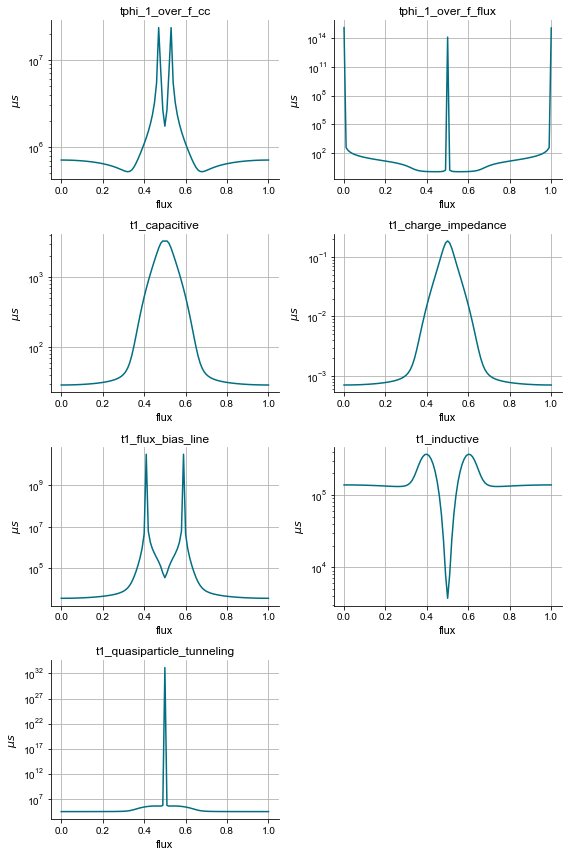

In [21]:
_sys.plot_coherence_vs_paramvals(param_name='flux', param_vals=param_vals)